# 2. A simple geological model

Following the basics of neural field interpolation outlined in the previous notebook (`01_neural_fields.ipynb`), we now use `curlew` to construct a simple geological model. 

This model contains two structural units:
1. A folded basement.
2. An unconformably overlying set of (gently dipping) cover units.

While we could interpolate these independently and then combine the results ourselves, `curlew` provides a framework that allows us to build a graph (chain) of neural fields to create composite models (`Geomodels`) in which each field represents a specific geological structure or event. These fields can be `prefit` individually, and/or `fit` as a single entity (which can be important for e.g., solving fault displacement).

#### Load some data

First, we will use the synthetic `curlew.hutton` model to generate some drillhole data to interpolate.

In [1]:
import curlew
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# for pretty plots
import matplotlib as mpl
mpl.rcParams["text.usetex"] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cmr10'
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['font.size'] = 18
plt.rcParams["axes.formatter.limits"] = [-2, 2]

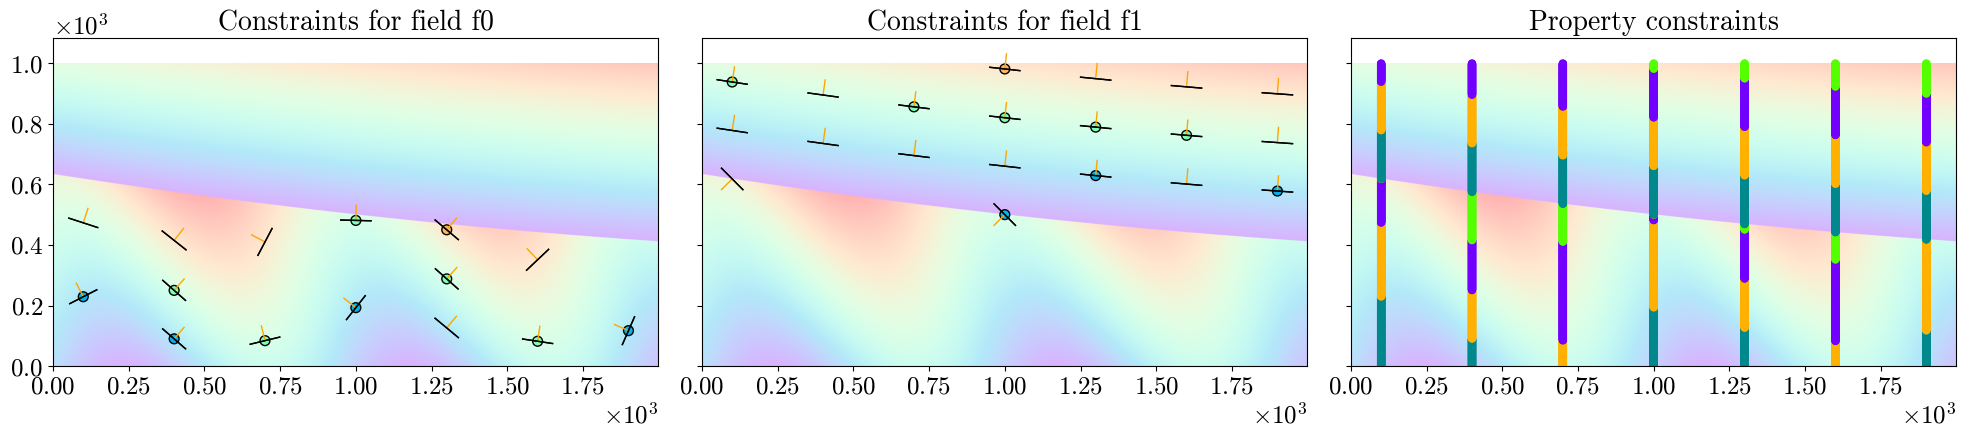

In [4]:
import curlew
from curlew.data import hutton

dims = (2000,1000)  # dimensions of our 2D section

# create the synthetic "hutton" dataset
# Note that (1) we use quite a high-contrast cmap to get some fake property data,
# and (2) we only sample "value" constraints 20% of the time, as often 
# geological observations cannot be easily attributed to a specific unit.
# (this intentionally results in significant uncertainty!)
C, Ms = hutton(dims, breaks=5, cmap='prism', pval=0.5)  # build synthetic model (using analytical fields)
s = Ms.predict(Ms.grid.coords())

ss=1
C[0].gp = C[0].gp[::ss] # throw away some constraints
C[0].gv = C[0].gv[::ss] 
C[0].gop = C[0].gop[::ss]
C[0].gov = C[0].gov[::ss] 

 # use a specific "drillhole" to pick isosurface values for basement
mask = np.logical_and(C[-1].pp[:,0] == 700, C[-1].vv[:,1] == 0)
contacts = np.argwhere( np.diff( C[-1].pv[mask, 0 ]) > 0 )
contacts = C[-1].pp[mask][contacts,:].squeeze()
levels = sorted( s.reshape(dims+(s.shape[-1],))[_x,_y,0] for (_x,_y) in contacts )

# plot it
from curlew.visualise import plot2D
fig,ax = plt.subplots(1,len(C),figsize=(20,12), sharex=True, sharey=True)
for i,_C in enumerate(C):
    plot2D( s[:,0], Ms.grid, C=_C, ax=ax[i], levels=levels ) # plot scalar field and associated constraints
    ax[i].set_title("Constraints for field f%d"%i)
ax[-1].set_title("Property constraints")
fig.tight_layout()
plt.show()

#### Build a simple model

Geological models in `curlew` are constructed by creating linked lists of Geological Neural Fields (`curlew.geology.SF`). These each contain an underlying interpolator (`curlew.NF`), as explored in the previous notebook, but have `younger` and `older` attributes that allow them to be chained together as linked lists.



In [5]:
from curlew import HSet
from curlew import GeoModel
from curlew.geology import strati
from curlew.geometry import grid

# define a random grid of control points to evaluate "global" losses
# (this random grid will be sampled during each epoch!)
Ms.grid.sampleArgs = dict(N=4096) # define how many random samples to select during training
for _C in C:
    _C.grid = Ms.grid
    _C.delta = 50 # numerical differentiation step used (in each axis)

# define interpolator for basement field
H = HSet( value_loss='1.0', mono_loss="0.05", thick_loss=0)
s0 = strati('basement', # name for this scalar field
            C[0], # constraints for this field
            H, # interpolator hyperparameters
            base=-np.inf, # basal surface (important for unconformities)
            input_dim=2, # field input coordinate dimensions (2D in our case)
            hidden_layers=[32,], # hidden layers in the multi-layer perceptron that parameterises our field
            rff_features=64, # number of random sin and cos features to create for each scale 
            length_scales=[500,]) # the length scales in our model

# define interpolator for unconformity field
s1 = strati('unconformity', # name of created structural field (SF)
            C[1], # constraints for this field
            H.copy(value_loss='1.0', thick_loss="1.0"), # change some hyperparams
            base='base', # basal surface (important for unconformities). In this case we give it a location rather than a fixed value.
            input_dim=2, # field input coordinate dimensions (2D in our case)
            hidden_layers=[32], # hidden layers in the multi-layer perceptron that parameterises our field
            rff_features=64, # number of random sin and cos features to create for each scale 
            length_scales=[2000,]) # the length scales in our model

# the value of the unconformity field at position (1000, 500) will be used to define the isosurface called "base".
# A constant value could also be specified (e.g., zero), but the use of one or more "seed" points allows a lot more
# flexibility, and often helps the model to converge better.
s1.addIsosurface('base', seed=(1000, 500 ))

In [6]:
# combine into a geomodel
M = GeoModel([s0,s1], grid=Ms.grid) 

# fit scalar fields independently
loss = M.prefit( epochs=500 )

unconformity: 500/500|, value_loss=0.0121, grad_loss=0.174, thick_loss=0.00239, mono_loss=3.6e-5 
Evaluating: 100%|██████████| 200/200 [00:00<00:00, 19068.92it/s]
basement: 500/500|, value_loss=0.000467, grad_loss=0.000565, mono_loss=0.0163


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 76.78it/s]


Text(0.5, 1.0, 'Field ID (generative event)')

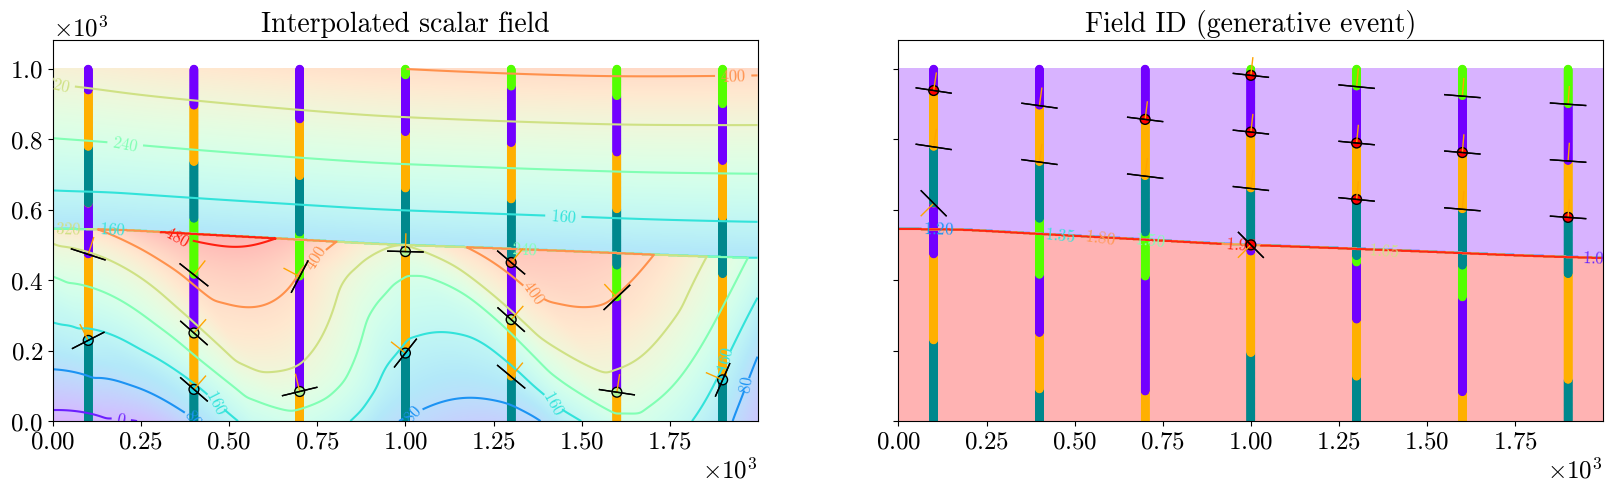

In [7]:
# evaluate scalar field
# N.B. we do this in batches to avoid using too much ram
from curlew.utils import batchEval
pred = batchEval( M.grid.coords(), M.predict )

# get isosurfaces to plot (given contact points from first drillhole)
levels = sorted([float(np.min(s0.predict( c )[:,0])) for c in contacts])

# plot it and the associated "structure id" field
fig,ax = plt.subplots(1,2,figsize=(20,10),sharex=True, sharey=True)
plot2D( pred[:,0], M.grid, C=C[0], ax=ax[0] ) # plot predicted field
plot2D( pred[:,1], M.grid, C=C[1], ax=ax[1] ) # plot predicted field
plot2D( None, M.grid, C=C[-1], ax=ax[0], levels=False ) # plot predicted field
plot2D( None, M.grid, C=C[-1], ax=ax[1], levels=False ) # plot predicted field

ax[0].set_title("Interpolated scalar field")
ax[1].set_title("Field ID (generative event)")

And that is our first geological neural field model! Easy :-) 

The result clearly isn't a great fit to "reality" -- but that's normal as geological models are typically hugely underconstrainted.

#### Inequality constraints

A common problem during implicit modelling is that the value of the interpolated scalar field is somewhat arbitrary - we normally only care about the shape of it's isosurfaces. 

Typically one needs to choose how to encode data on e.g., stratigraphic unit as a scalar field value - which can then sometimes cause interpolation issues.

To get around this, *curlew* lets you define `inequality constraints`. These are structured as follows:

`(N, [ (lhs, rhs, inequality), ...])`

Such that N random pairs will be selected from the left hand side (lhs) and right hand side (rhs) arrays, and then compared according to the defined inequality (and losses accumulated where appropriate). As an example, we could define the following:

`(100, (unit_1_points, unit_2_points, '>'))`

During our loss calculation, 100 random pairs would be compared between `unit_1_points` and `unit_2_points`, the difference in predicted scalar field computed for each of these pairs, and losses accumulated where the sampled `unit_1_points` give greater values than the sampled `unit_2_points`. Even with a relatively small `N`, most combinations of pairs should be sampled over the training epochs.

To demonstrate this, we will rebuild the previous model, but using only gradient and inequality constraints.

In [8]:
# use drillcore data (properties) to get an "id" for each lithology
basement = C[-1].vv[:,1] == 2 # ignore unconformity values
l1 = basement * (C[-1].vv[:,0] > 400) # N.B. * operator gives us a logical andlayer2 = np.logical_and( basement, C[-1].vv[:,0] > 400 )
l2 = basement * (C[-1].vv[:,0] < 400) * (C[-1].vv[:,0] > 250)
l3 = basement * (C[-1].vv[:,0] < 250)

# ordered stratigraphy array containing the positions of points known to be in each layer
layers = [C[-1].vp[msk,:] for msk in [l1, l2, l3] ] 
import itertools
C[0].iq = (1024,[]) # sample 1024 pairs from the inequalities added in the next loop
for i in range(1,len(layers)):
    # get points for constraint lhs < rhs (given "layers" is a stratigraphically ordered list)
    lhs = list(itertools.chain.from_iterable(layers[0:i])) # list containing lhs points
    rhs = list(itertools.chain.from_iterable(layers[i:len(layers)])) # list containing rhs points
    C[0].iq[1].append((np.vstack(lhs), np.vstack(rhs),'>'))

Rebuild the above model using inequality constraints only

In [9]:
from curlew import HSet, GeoModel
from curlew.geology import strati

# define a random grid of control points to evaluate "global" losses
# (this random grid will be sampled during each epoch!)
Ms.grid.sampleArgs = dict(N=4096) # define how many random samples to select during training
for _C in C:
    _C.grid = Ms.grid
    _C.delta = 50 # numerical differentiation step used (in each axis)

# define interpolator for basement field, disabling value losses
H = HSet( value_loss=0, iq_loss='0.1', mono_loss="0.1", thick_loss=0)
s0 = strati('basement', # name for this scalar field
            C[0], # constraints for this field
            H, # interpolator hyperparameters
            base=-np.inf, # basal surface (important for unconformities)
            input_dim=2, # field input coordinate dimensions (2D in our case)
            hidden_layers=[32,], # hidden layers in the multi-layer perceptron that parameterises our field
            rff_features=64, # number of random sin and cos features to create for each scale 
            length_scales=[500,]) # the length scales in our model

# define interpolator for unconformity field
H = HSet( value_loss='1.0', iq_loss=0, mono_loss="0.05", thick_loss='1.0')
s1 = strati('unconformity', # name of created structural field (SF)
            C[1], # constraints for this field
            H, # change some hyperparams
            base='base', # basal surface (important for unconformities). In this case these have a value of 0.
            input_dim=2, # field input coordinate dimensions (2D in our case)
            hidden_layers=[32], # hidden layers in the multi-layer perceptron that parameterises our field
            rff_features=64, # number of random sin and cos features to create for each scale 
            length_scales=[2000,]) # the length scales in our model
s1.addIsosurface('base', seed=(1000, 500))

In [10]:
# combine into a geomodel
M = GeoModel([s0,s1], grid=Ms.grid) 

# fit scalar fields independently
loss = M.prefit( epochs=500 )

unconformity: 500/500|, value_loss=0.0108, grad_loss=0.174, thick_loss=0.00213, mono_loss=0.0002  
Evaluating: 100%|██████████| 200/200 [00:00<00:00, 16860.51it/s]
basement: 485/500|, grad_loss=0.00289, mono_loss=0.0174, iq_loss=0.000729


Evaluating: 100%|██████████| 200/200 [00:02<00:00, 76.13it/s]


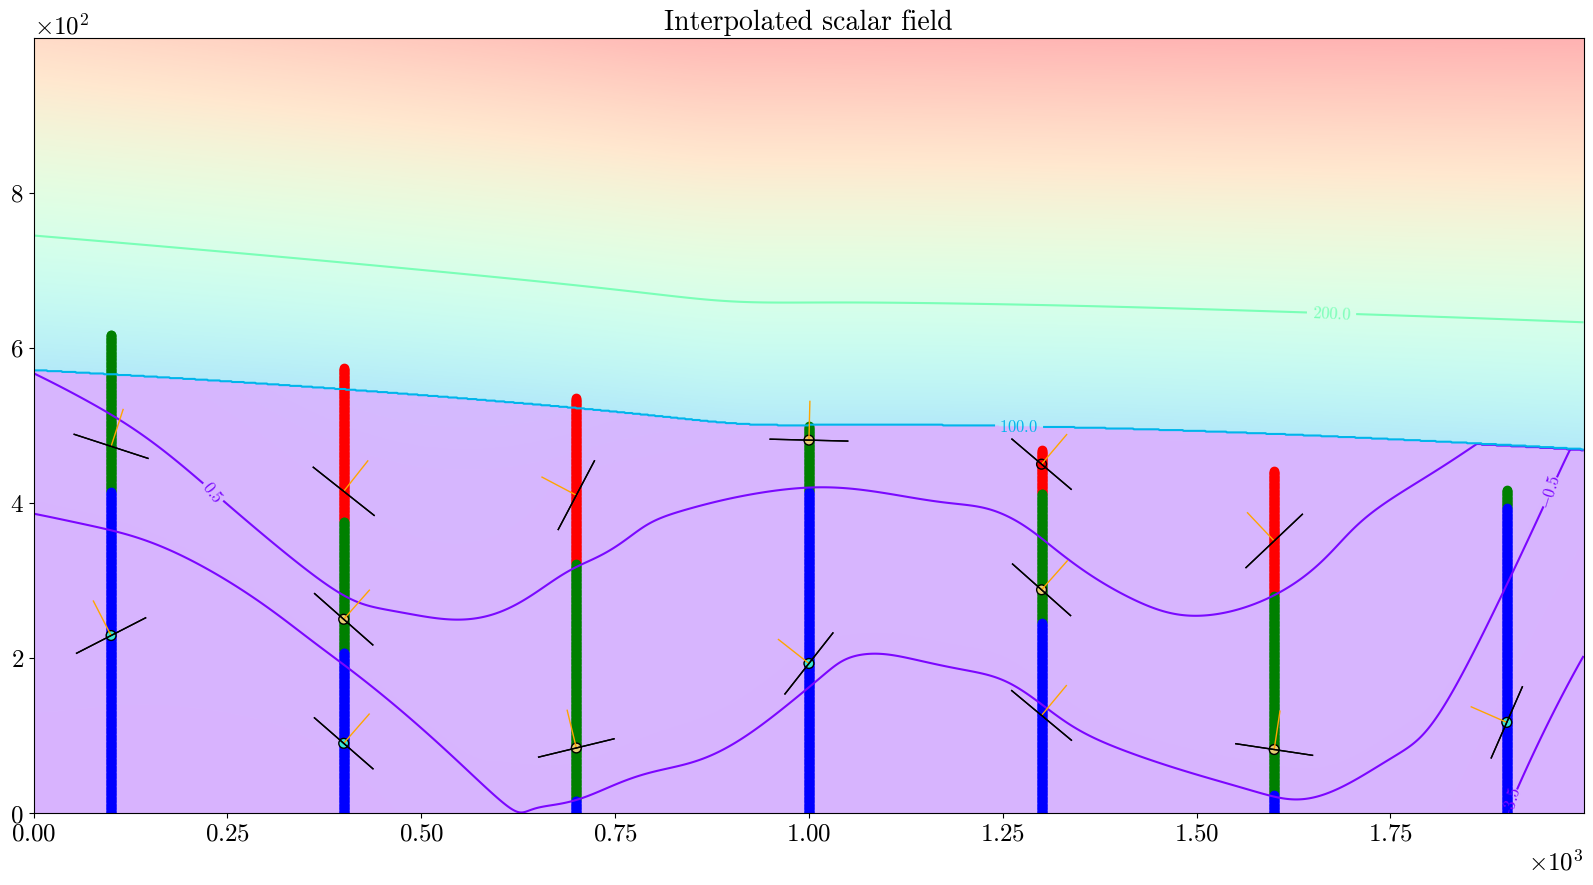

In [11]:
# evaluate scalar field
# N.B. we do this in batches to avoid using too much ram
from curlew.utils import batchEval
pred = batchEval( M.grid.coords(), M.predict )

# predict values at contact points
levels = sorted([float(np.min(s0.predict( C[-1].pp[m,:] )[:,0])) for m in [l1,l2,l3]]) + [100,200]

# plot it and the associated "structure id" field
fig,ax = plt.subplots(1,1,figsize=(20,15),sharex=True, sharey=True)
plot2D( pred[:,0], M.grid, C=C[0], ax=ax, levels=levels ) # plot predicted field
ax.set_title("Interpolated scalar field")

for c,m in zip(['r','g','b'],[l1,l2,l3]):
    ax.scatter( C[-1].pp[m,0], C[-1].pp[m,1], c=c )

#### Property constraints

Finally, one of the most powerful aspects of Neural Fields is their ability to fit to relatively arbitrary data through a learnable forward model.

In the following we'll explore this, using `Property constraints`.

Property constraints are some measurable (i.e. quantitative) property on which we have information at specific points. These could be e.g., chemistry attributes from drillcore assays, or hyperspectral features core or outcrop scans.

Property data indirectly constrain the geometry of our scalar fields: Good models will explain the distribution of properties, such that regions with similar scalar field values have similar measured properties. We can (weakly) enforce these by adding a `property` field to our geological model.

The property field is an additional neural network that takes the scalar field value (and corresponding structural element ID) as input, and predicts property values. In doing so it learns a forward model that we can derive a reconstruction loss to optimise our model in a way that explains the property distribution.

In [12]:
from curlew import NF
from torch import nn

# create a forward model (NF instance)
M.forward = NF( HSet().zero(prop_loss="1.0"), # zero all hyperparams except property loss
               name = 'forward', 
               input_dim=2, # two inputs - (scalar_value, field_id )
               output_dim=3, # one output for each measured property [ R, G, B ]
               hidden_layers=[128,256,256,128], # build a bigger network here; we need nonlinearity
               activation=nn.ReLU(), # this is a more conventional MLP
               loss=nn.MSELoss(),# nn.L1Loss(), # play with the loss function -- it makes quite a big difference!
               rff_features=0  ) # don't use fourier features

M.forward.bind(C[-1]) # add property constraints 
                      # (in this case all our fields have property constraints)

In [13]:
# now train everything together, to let geometry adapt given the forward model!
#M.freeze([s1], geometry=True) # keep unconformity geometry fixed as we already like it :-) 
loss = M.fit( 5000, learning_rate=0.001 )

Training: 106/5000|, unconformity=10.6, basement=0.0187, forward=9.43e+3


In [14]:
sdims, sxy = grid( dims, step=(2,2), origin=(0,0) ) 

# evaluate scalar field
spred = M.predict( sxy )

# evaluate predicted property field using forward model
ppred = M.forward.predict( spred )

# plot it and the associated "structure id" field
fig,ax = plt.subplots(1,2,figsize=(20,10),sharex=True, sharey=True)
plot2D( sxy, spred[:,0], sdims[:-1], C=C[-1], ax=ax[0] ) # plot predicted field
plot2D( sxy, np.clip(ppred/255,0,1), sdims[:-1], C=C[-1], ax=ax[1], levels=False ) # plot predicted field

ax[0].set_title("Interpolated scalar field")
ax[1].set_title("Predicted property field")

TypeError: cannot unpack non-iterable Grid object

The result is a little "80s", but clearly fits our ground truth better than the model without property constraints! It's not perfect - but folds are tricky...